In [5]:
from __future__ import division
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from __future__ import division
import matplotlib.pyplot as plt
from pylab import *
import numpy as np
import cv2
from tensorflow.keras.datasets import mnist
import math
from PIL import Image

2023-06-19 09:26:51.380679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [104]:
verbose = False

class IsingModel:

  def __init__(self,Y,alpha,beta, sigma_sqrd):
    # X = height x width
    # Gibbs distribution parameters : alpha, beta
    height,width = Y.shape
    X=Y.copy()
    self.height = height
    self.width = width
    self.alpha = alpha
    self.beta = beta
    self.X = X
    self.ss = sigma_sqrd
    self.Y = Y  # Y = Observed noisy image.


  def show(self,name):
      plt.figure(name)
      plt.imshow(self.X,cmap=cm.Greys_r)
      plt.show()


  def get_neighbors(self,i,j):
    neighbors = []
    #adding elements that have smaller linear index first
    neighbors.extend(([i-1,j-1], [i-1,j], [i-1,j+1]))
    neighbors.extend(([i,j-1], [i, j+1]))
    neighbors.extend(([i+1,j-1], [i+1,j], [i+1,j+1]))
    #
    #neighbors.extend(([i-1,j+1],[i,j+1],[i+1,j+1]))
    #neighbors.extend(([i-1,j],[i+1,j]))
    #neighbors.extend(([i-1,j-1],[i,j-1],[i+1,j-1]))
    #take care of the boundaries.
    for n in range(len(neighbors)):
      [a,b] = neighbors[n]
      a = 0 if a<0 else a
      b = 0 if b<0 else b
      a = self.height-1 if a>=self.height else a
      b = self.width-1 if b>=self.width else b
      neighbors[n] = [a,b]
    #remove all occurrences if [i,j] from neighbors
    neighbors[:] = [a for a in neighbors if a != [i,j]]
    return neighbors


  def unnormalized_probability(self):
    energy = self.alpha * np.sum(self.X)
    pairwise = 0
    for i in range(self.height):
      for j in range(self.width):
          neighbors = self.get_neighbors(i,j)
          for neighbor_index in neighbors:
              pairwise += self.X[i,j]*self.X[neighbor_index[0],neighbor_index[1]]
    pairwise /= 2 #as each pair is counted twice
    energy += -self.beta * pairwise
    if verbose:
       print('energy=%f'%(energy))
    return np.exp(-energy)

  def conditional_probability(self,i,j):
      #print('cond denoise')
      neighbors = self.get_neighbors(i,j)
      energy = -self.alpha + self.beta*np.sum( self.X[x,y] for (x,y) in neighbors )
      term1 = np.exp(energy - (0.5/self.ss)*((self.Y[i,j]-1)**2) )
      term2 = np.exp(-energy - (0.5/self.ss)*((self.Y[i,j]+1)**2) )
      Prob_Xij_one_given_neighbors = float(term1)/(term1+term2)
      Prob_Xij_minus_one_given_neighbors = 1.0 - Prob_Xij_one_given_neighbors #float(term2)/(term1+term2)
      return [Prob_Xij_minus_one_given_neighbors,Prob_Xij_one_given_neighbors]

  def Gibbs_sampling(self,z):
    # z = [i,j]
    # sample from P( X[z] | N(X[z]) )
    i,j = z
    p_minus_one,p_one = self.conditional_probability(i,j)
    self.X[i,j]=-1 if np.random.rand()<=p_minus_one else 1

  def Metropolis_Hastings(self,z):
    i,j=z
    x=self.X[i,j]
    neighbors = self.get_neighbors(i,j)
    # Calculate acceptance propability
    # We don't take exponential. Instead, we take the log of random number. This is more stable.
    delta = np.exp(-2*self.X[i,j]*self.Y[i,j]/(self.ss) +2*self.alpha -2*self.X[i,j]*self.beta*np.sum( self.X[x,y] for (x,y) in neighbors ))
    delta_E=min(1, delta)
    # Flip the pixel if accepted
    self.X[i,j]= x*(-1) if np.random.rand()<=delta else x

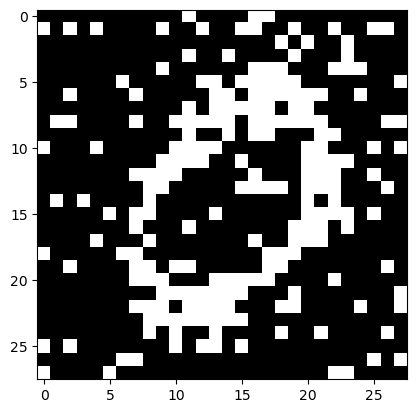

In [105]:
#read grayscale image, convert to binary
(X_train, _), (_, _) = mnist.load_data()

im = X_train[1]
_,im_binary = cv2.threshold(im,127,1,cv2.THRESH_BINARY)
im_binary = (im_binary.astype(int) * 2) - 1

#create a noisy binary image
noise = np.random.random(im_binary.shape)
noise = where(noise<0.15,-1,1)
Y = np.array(im_binary*noise) #observed noisy binary image.

height,width = Y.shape
N = height*width

imgplot = plt.imshow(Y, cmap = cm.Greys_r)
plt.show()

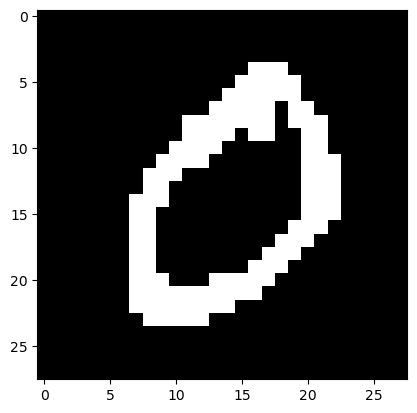

In [106]:
imgplot = plt.imshow(im_binary, cmap = cm.Greys_r)
plt.show()

# **Gibbs**

Running 5 burn-in iterations...
burin_in = 0 
burin_in = 784 
burin_in = 1568 
burin_in = 2352 
burin_in = 3136 
Sampling 7840 samples using Gibbs...
s = 0 
s = 784 
s = 1568 
s = 2352 
s = 3136 
s = 3920 
s = 4704 
s = 5488 
s = 6272 
s = 7056 


/tmp/ipykernel_6223/3078112968.py:65: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  energy = -self.alpha + self.beta*np.sum( self.X[x,y] for (x,y) in neighbors )


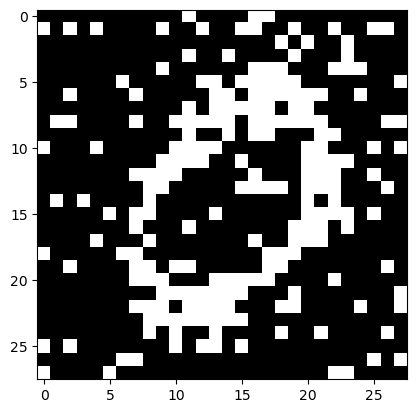

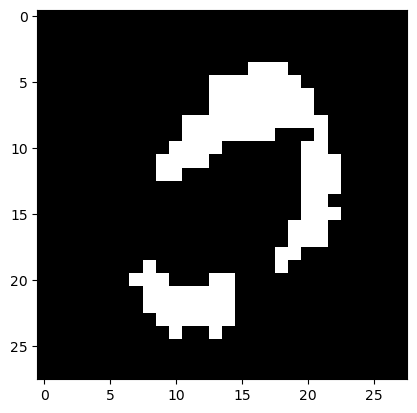

In [107]:

alpha = 0.0
beta = 0.3
sigma_squared = 1.4
num_burnin = 5
num_samples = 10
N = height*width

IMD = IsingModel(Y,alpha,beta,sigma_squared)

print('Running %d burn-in iterations...'%(num_burnin))
#burn-in iterations.
for n_burn_in in range(num_burnin):
   print('burin_in = %d '%(n_burn_in*N))
   for i in range(0,height):
      for j in range(0,width):
         IMD.Gibbs_sampling([i,j])

print('Sampling %d samples using Gibbs...'%(N*num_samples))
#now generate samples and take average.
avg = np.zeros_like(Y)

for n_samp in range(num_samples):
  print('s = %d '%(n_samp*N))
  for i in range(0,height):
      for j in range(0,width):
          IMD.Gibbs_sampling([i,j])
          avg += IMD.X

avg = avg.astype(float)
avg = avg/(N*num_samples)
avg[avg >= 0] = 1
avg[avg < 0] = -1
avg = avg.astype(int)

plt.figure('noisy image')
imgplot = plt.imshow(Y, cmap = cm.Greys_r)

plt.figure('posterior mean after sampling')
imgplot = plt.imshow(avg, cmap = cm.Greys_r)

plt.show()

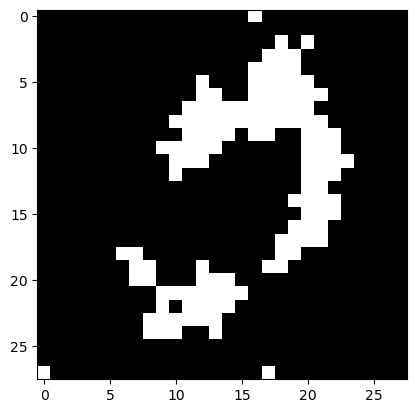

In [108]:
plt.figure('noisy image')
imgplot = plt.imshow(IMD.X, cmap = cm.Greys_r)
plt.show()

In [109]:
equal=0
for i in range(0,height):
      for j in range(0,width):
        a= im_binary[i,j]-avg[i,j]
        if(a==0):
          equal=equal+1

errorG=height*width-equal

# **Metropolis-Hastings**

Running 5 burn-in iterations...
burn_in = 0 
burn_in = 784 
burn_in = 1568 
burn_in = 2352 
burn_in = 3136 
Sampling 7840 samples using M-H...
s = 0 
s = 784 
s = 1568 
s = 2352 
s = 3136 
s = 3920 
s = 4704 
s = 5488 
s = 6272 
s = 7056 


/tmp/ipykernel_6223/3078112968.py:85: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  delta = np.exp(-2*self.X[i,j]*self.Y[i,j]/(self.ss) +2*self.alpha -2*self.X[i,j]*self.beta*np.sum( self.X[x,y] for (x,y) in neighbors ))


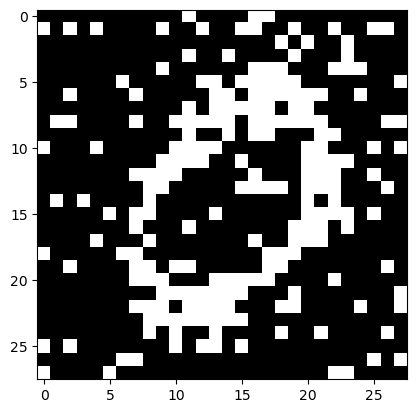

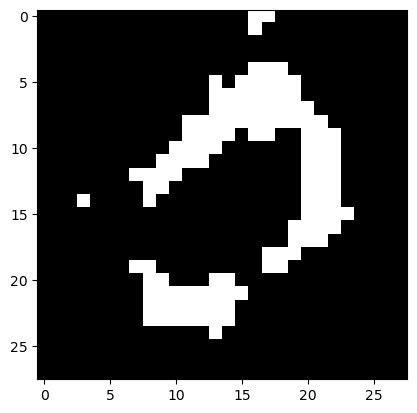

In [110]:

IMD = IsingModel(Y,alpha,beta,sigma_squared)
print('Running %d burn-in iterations...'%(num_burnin))
#burn-in iterations.
for n_burn_in in range(num_burnin):
   print('burn_in = %d '%(n_burn_in*N))
   for t in range(height*width):
         i,j = np.random.choice(height), np.random.choice(width)
         IMD.Metropolis_Hastings([i,j])

print('Sampling %d samples using M-H...'%(N*num_samples))
#now generate samples and take average.
avg = np.zeros_like(Y)



for n_samp in range(num_samples):
  print('s = %d '%(n_samp*N))
  for t in range(height*width):
         i,j = np.random.choice(height), np.random.choice(width)
         IMD.Metropolis_Hastings([i,j])
         avg += IMD.X

avg = avg.astype(float)
avg = avg/(N*num_samples)
avg[avg >= 0] = 1
avg[avg < 0] = -1
avg = avg.astype(int)



plt.figure('noisy image')
imgplot = plt.imshow(Y, cmap = cm.Greys_r)

plt.figure('posterior mean after sampling')
imgplot = plt.imshow(avg, cmap = cm.Greys_r)

plt.show()

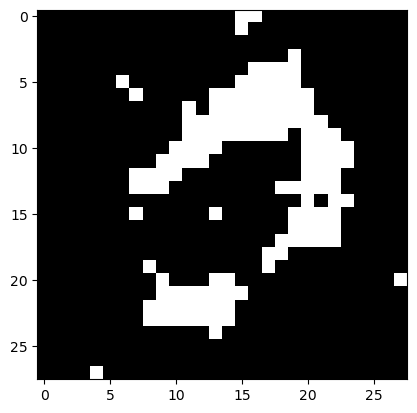

In [111]:
plt.figure('noisy image')
imgplot = plt.imshow(IMD.X, cmap = cm.Greys_r)
plt.show()

In [112]:
equal=0
for i in range(0,height):
      for j in range(0,width):
        a= im_binary[i,j]-avg[i,j]
        if(a==0):
          equal=equal+1

errorM=height*width-equal

## Percentuale pixel sbagliati

In [113]:
epG=(errorG*100)/(height*width)
epG

5.229591836734694

In [114]:
epM=(errorM*100)/(height*width)
epM

4.591836734693878

# Nuova tecnica cluster

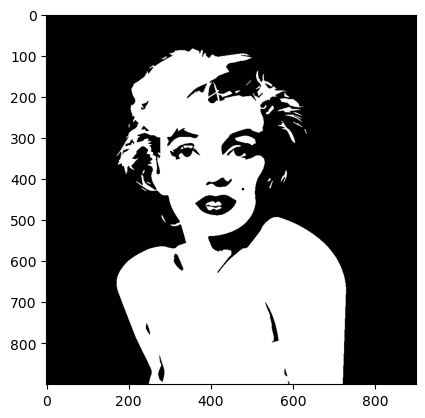

In [115]:
from PIL import Image

imgX = Image.open("MArylin.JPG")  # open colour image
imgX = imgX.convert('L')
img = np.asarray(imgX)
img = 2*(img > 128).astype(int)-1
plt.imshow(img,cmap='gray',vmin=-1,vmax=1)
plt.show()

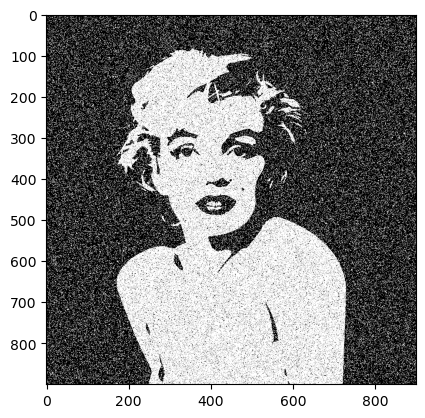

In [116]:
#create a noisy binary image
noise = np.random.random(img.shape)
noise = where(noise<0.15,-1,1)
Y = np.array(img*noise) #observed noisy binary image.

height,width = Y.shape
N = height*width

imgplot = plt.imshow(Y, cmap = cm.Greys_r)
plt.show()

In [117]:
import math

# find cluster size
def clus_size(image):
    n = len(image)      # check if this works
    divisors = []
    result = 0
    upperbound = int(math.sqrt(n))
    for i in range(1, upperbound + 1):
        if n % (i * i) == 0:
            divisors.append(i * i)
    
    for candidate in divisors:
        if(candidate <= 10):
            result = candidate
        else:
            print(f"Cluster size proposal is {result} pixels")
            return result

    return result

In [118]:
def get_clust_val(image, clus_size, index):
    side = int(sqrt(clus_size))
    row = index[0]*side
    col = index[1]*side

    indexes = []
    value = sum(image[row: row + side -1, col : col + side -1])

    return 1 if value > 0 else -1


In [119]:
def smaller_image(image):
    c_size = clus_size(image)
    if c_size <= 1:
        print("Error on cluster size")
        return 0
    
    rows = int(shape(image)[0]/sqrt(c_size))
    cols = int(shape(image)[1]/sqrt(c_size))
    new_img = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            new_img[i,j] = get_clust_val(image, c_size, (i,j))
    
    plt.imshow(new_img,cmap='gray',vmin=-1,vmax=1)
    print(shape(new_img))

Cluster size proposal is 9 pixels
(300, 300)


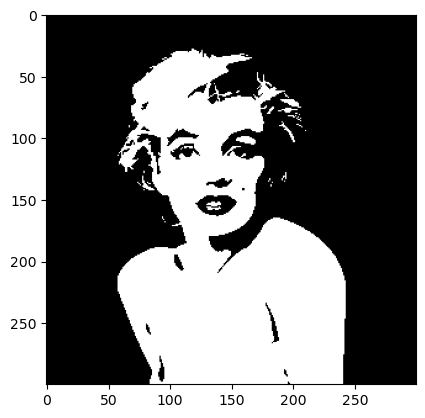

In [120]:
smaller_image(img)